Name: Xiang Li
NetID: xl649

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from sklearn.manifold import MDS

In [3]:
#load data
face_dataset = fetch_olivetti_faces()
face_data = face_dataset.data
face_target = face_dataset.target

In [5]:
#standardization
scaler = preprocessing.StandardScaler()
face_data_standardized = scaler.fit_transform(face_data)
print(face_data_standardized[:,:5].mean(axis = 0))
print(face_data_standardized[:,:5].std(axis = 0))

[ 2.07126138e-08 -1.07288365e-08  2.11596483e-08 -2.41398812e-08
  1.06096266e-07]
[0.9999995 1.0000004 1.        1.        1.       ]


mean is close to zero, and standard deviation is equal to 1. good to go

# **1. PCA from Scratch.**

In [6]:
def pca(data,k, explain_ratio = False):
    #compute covariance matrix
    cov_matrix = np.cov(data, rowvar=False)
    #compute eigen values and corresponding eigen vectors
    eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
    #sort eigen values in indeces and flip it into descending order
    sorted_components = np.argsort(eigen_values)
    sorted_components = np.flip(sorted_components)
    #pick top k eigen vectors as feature vectors
    feature_vectors = eigen_vectors[:,sorted_components[:k]]
    if explain_ratio:
        explained_variance = eigen_values[sorted_components]
        explained_variance_ratio = explained_variance / eigen_values.sum()
        return np.dot(data, feature_vectors), feature_vectors, explained_variance_ratio
    return np.dot(data, feature_vectors), feature_vectors

def inverse_transform(data, feature_vectors):
    return np.dot(data, feature_vectors.T)

Here, we use top-2 components PCA, and color it by its class(face_target)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


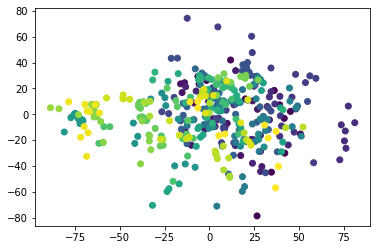

In [7]:
pca_data, feature_vectors, explained_variance_ratio = pca(face_data_standardized, 2, explain_ratio = True)
plt.figure()
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = face_target)

The above plot shows even top-2 PCA can maintain some features of original data, dots with the same color tend to fall closer to each other.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'cumulative explained variance')

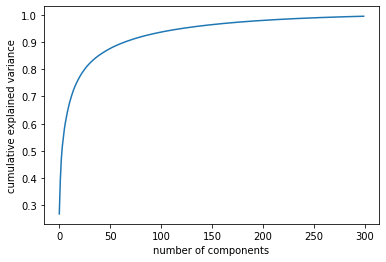

In [8]:
plt.plot(np.cumsum(explained_variance_ratio[:300]))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

The above plot shows cumulative explained variance, as the number of components get close to 200, PCA can explain about 95% variance. Thus, we will set k = 200.

# **2. Unroll PCA**

In [9]:
pca_data, feature_vectors = pca(face_data_standardized, 200)
inversed_pca = inverse_transform(pca_data, feature_vectors)
#destandardize
inversed_pca_destd = scaler.inverse_transform(inversed_pca.real)

The average difference of each image

In [10]:
avg_diff = abs(face_data - inversed_pca_destd).mean(axis = 1)
print(avg_diff)

[0.01610597 0.01496331 0.01543249 0.01617178 0.01367391 0.01374193
 0.01696572 0.01622022 0.01560878 0.00993781 0.01409939 0.01491567
 0.01025638 0.01239878 0.01197974 0.01474935 0.01366883 0.01666088
 0.01309924 0.01705473 0.01664944 0.0147057  0.01515377 0.01304703
 0.01308125 0.01437457 0.01505291 0.01631992 0.01640881 0.01534039
 0.01228285 0.01149258 0.00948298 0.01520304 0.01568088 0.0167052
 0.01757358 0.01389144 0.00917141 0.01612749 0.01401458 0.01547866
 0.01528287 0.01372528 0.0158499  0.01650994 0.01574001 0.01505436
 0.01731496 0.01683126 0.01698208 0.01784464 0.01658494 0.01687112
 0.01550682 0.01670848 0.0166558  0.01813462 0.01512866 0.01613089
 0.01695453 0.00986139 0.01456194 0.00916782 0.0101327  0.01421156
 0.00958286 0.01574074 0.01252288 0.00637067 0.01482737 0.01554829
 0.01514396 0.01568195 0.01612133 0.01608714 0.01383483 0.0155348
 0.01103331 0.01400124 0.01507969 0.01635566 0.01465643 0.01476036
 0.01588014 0.01649632 0.01630628 0.01640283 0.01483559 0.017098

The average difference across all images

In [11]:
avg_diff.mean()

0.014937410509388536

In [12]:
inverse_mse = ((face_data - inversed_pca_destd)**2).mean()
print(inverse_mse)

0.0004138807229649733


MSE between them is pretty low, inverse_transform succeed

# **3. Use the faces dataset to compare the distance matrix in pixel space versus the distance matrix in PCA space**

(a) The ideal fit would keep the relative distance between each image in multi-dimentin space

In [13]:
#compute distance matrix
dm_face_data = pairwise_distances(face_data)
dm_pca_data = pairwise_distances(pca_data.real)
dm_std_face_data = pairwise_distances(face_data_standardized)

In [14]:
print(dm_face_data)

[[ 0.        12.699108   6.5857997 ... 13.592082  12.737838  11.593747 ]
 [12.699108   0.        12.025274  ... 11.965294  18.113447  13.650752 ]
 [ 6.5857997 12.025274   0.        ... 12.719544  13.587719  11.87047  ]
 ...
 [13.592082  11.965294  12.719544  ...  0.        14.550293   9.516407 ]
 [12.737838  18.113447  13.587719  ... 14.550293   0.        10.568364 ]
 [11.593747  13.650752  11.87047   ...  9.516407  10.568364   0.       ]]


In [15]:
print(dm_pca_data)

[[  0.          84.1161899   40.27439564 ...  95.60854754  87.24541589
   81.32492164]
 [ 84.1161899    0.          80.58992139 ...  84.57166564 121.9356258
   93.68677511]
 [ 40.27439564  80.58992139   0.         ...  90.7092892   91.98697701
   83.096519  ]
 ...
 [ 95.60854754  84.57166564  90.7092892  ...   0.         100.34791958
   64.56550137]
 [ 87.24541589 121.9356258   91.98697701 ... 100.34791958   0.
   76.07386542]
 [ 81.32492164  93.68677511  83.096519   ...  64.56550137  76.07386542
    0.        ]]


The distance matrices of face_data and pca_data look quit different but correlated?

In [16]:
dm_face_data/dm_pca_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan, 0.15097103, 0.16352324, ..., 0.14216388, 0.14600008,
        0.14256082],
       [0.15097103,        nan, 0.14921561, ..., 0.14148112, 0.14854926,
        0.14570629],
       [0.16352324, 0.14921561,        nan, ..., 0.14022317, 0.14771351,
        0.14285159],
       ...,
       [0.14216388, 0.14148112, 0.14022317, ...,        nan, 0.14499845,
        0.14739151],
       [0.14600008, 0.14854926, 0.14771351, ..., 0.14499845,        nan,
        0.1389224 ],
       [0.14256082, 0.14570629, 0.14285159, ..., 0.14739151, 0.1389224 ,
               nan]])

An interesting thing we find here is that the ratio of the distance in face_data to the distance in PCA space seems to be a constant 0.15. This is probably due to the standardization. Thus the points(images) in PCA space remain their relative position. 

Let's compare distance matrix of standardized face_data and distance matrix of pca_data

In [17]:
print(dm_std_face_data)

[[  0.        85.336716  42.685394 ...  96.618744  88.29316   82.358315]
 [ 85.336716   0.        81.69745  ...  85.55668  122.74274   94.58017 ]
 [ 42.685394  81.69745    0.       ...  91.68594   92.887924  83.93699 ]
 ...
 [ 96.618744  85.55668   91.68594  ...   0.       101.29323   65.80682 ]
 [ 88.29316  122.74274   92.887924 ... 101.29323    0.        77.17306 ]
 [ 82.358315  94.58017   83.93699  ...  65.80682   77.17306    0.      ]]


In [20]:
dm_std_face_data/dm_pca_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan, 1.01451   , 1.0598643 , ..., 1.01056596, 1.01200915,
        1.01270696],
       [1.01451   ,        nan, 1.01374275, ..., 1.01164708, 1.00661916,
        1.00953597],
       [1.0598643 , 1.01374275,        nan, ..., 1.01076686, 1.00979429,
        1.01011438],
       ...,
       [1.01056596, 1.01164708, 1.01076686, ...,        nan, 1.00942031,
        1.01922578],
       [1.01200915, 1.00661916, 1.00979429, ..., 1.00942031,        nan,
        1.01444901],
       [1.01270696, 1.00953597, 1.01011438, ..., 1.01922578, 1.01444901,
               nan]])

(c)Looks promising!! Now we find our PCA data stays a similar shap with standardized face data.

(b)Let's compute MSE, I will use scipy.spatial.distance.pdist to compute distance matrix, a nice thing about this function is it returns a condensed distance matrix instead of a square matrix.

In [21]:
cdm_pca_data = distance.pdist(pca_data.real, 'euclidean')
cdm_std_face_data = distance.pdist(face_data_standardized, 'euclidean')
dm_mse = mean_squared_error(cdm_pca_data, cdm_std_face_data)
print(dm_mse)

1.1986940198389542


The MSE is pretty low, which means PCA with top 200 components barely distored the orinal image. Thus, a good fit.

(d)Lets compare first 200 the distance in PCA space and the distance in pixel space

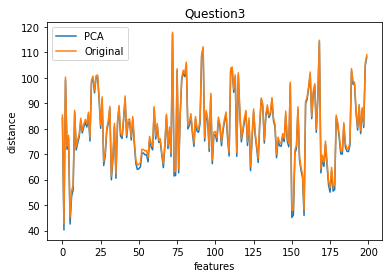

In [24]:
plt.figure()
plt.plot(cdm_pca_data[:200], label='PCA')  # Plot some data on the (implicit) axes.
plt.plot(cdm_std_face_data[:200], label='Original')  # etc.
plt.xlabel('features')
plt.ylabel('distance')
plt.title("Question3")
plt.legend();

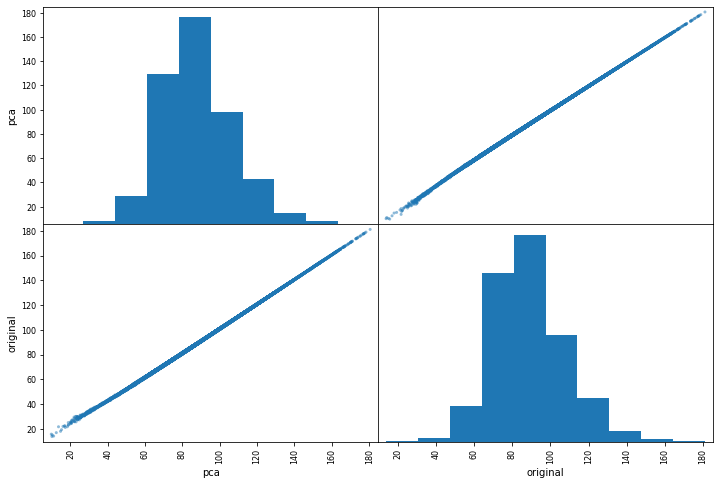

In [25]:
dm_df = pd.DataFrame({'pca':cdm_pca_data,'original':cdm_std_face_data})
scatter_matrix(frame=dm_df, figsize=(12, 8))
plt.show()

the distances are highly correlated

# **4.MDS**

(a)The ideal fit still should be retaining the relative distance between images in their space.

(b)Calculate MSE between distance matrix of mds and distance matrix of face data

In [26]:
mds = MDS(n_components=200)
mds_data = mds.fit_transform(face_data)
cdm_mds_data = distance.pdist(mds_data, 'euclidean')
cdm_face_data = distance.pdist(face_data, 'euclidean')
dm_mse_mds = mean_squared_error(cdm_mds_data, cdm_face_data)
print(dm_mse_mds)

0.01988116070450914


(c)The error is super low, we almost have an ideal fit.

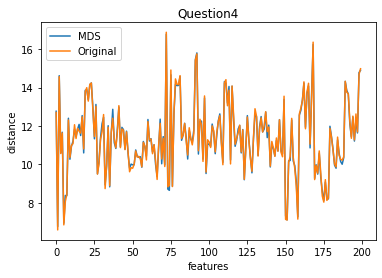

In [27]:
plt.figure()
plt.plot(cdm_mds_data[:200], label='MDS')  # Plot some data on the (implicit) axes.
plt.plot(cdm_face_data[:200], label='Original')  # etc.
plt.xlabel('features')
plt.ylabel('distance')
plt.title("Question4")
plt.legend();

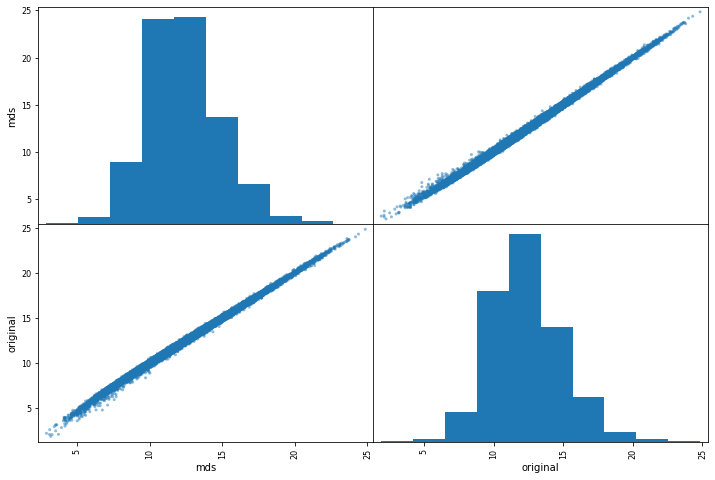

In [28]:
dm_df_mds = pd.DataFrame({'mds':cdm_mds_data,'original':cdm_face_data})
scatter_matrix(frame=dm_df_mds, figsize=(12, 8))
plt.show()

As we suspect, the distances are highly correlated. MDS is doing a better job than PCA in terms of minimizing errors in distance in projective space.